In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import cm
from tqdm import tqdm
import seaborn as sns

In [ ]:
def ecdf(data, missing):
	""" Compute ECDF  with missing data 
		
		Inputs
		------
		data : array of data
		missing : index of missing data
		
		Outputs
		-------
		empirical cumulative distribution function
	"""
	index = np.argsort(data)
	ecdf = np.zeros(len(index))
	for i in index:
		ecdf[i] = (1.0 / np.sum(missing)) * np.sum((data <= data[i]) * missing) # compute ecdf
		
        
	return ecdf
	
def dist(X, lmbd, missing):
	"""
		Compute matrix of F-Madogram (a une constante pres) using the empirical cumulative distribution function
		
		Inputs
		------
		X : a matrix composed of ecdf
		lmbd : a parameter between 0 and 1
		missing : vector indicate if we have the complete value

		Outputs
		-------
		A matrix with quantity equals to 0 if i=j (diagonal) and equals to sum_t=1^T |F(X_t)^{\lambda} - G(Y_t)^{1-\lambda}| if i \neq j
	"""
	ncols = X.shape[1]
	nrows = X.shape[0]
	X = np.multiply(X, missing)
	dist = np.zeros([nrows, nrows])
	for i in range(0,nrows):
		for j in range(0,i):
			if i == j:
				dist[i,i] = 0
			else :
				F_x = X[i,:]
				G_y = X[j,:]
				d = np.linalg.norm(np.power(F_x,lmbd)-np.power(G_y,1-lmbd), ord = 1)
				dist[i,j] = d
				dist[j,i] = d
				
	return dist
	
def fmado(x, lmbd=0.5):
	"""
		This function
		
		Inputs
		------
		x : a matrix
		lmbd : constant between 0 and 1 use for the lambda F-madogram

		Outputs
		-------
		A matrix equals to 0 if i = j and equalts to |F(X)^{\lambda} - G(Y)^{1-\lambda}|
	"""
	
	Nnb = x.shape[1] // 2
	Tnb = x.shape[0]
	
	#--- Distance Matrix
	#--- F-Madogram
	V = np.zeros([Tnb, Nnb])
	for p in range(0, Nnb):
		x_vec = np.array(x[:,p]) # x
		miss = np.array(x[:, Nnb + p])
		Femp = ecdf(x_vec, miss)
		V[:,p] = Femp
	# With Madogram
	cross_missing = np.array([np.multiply(x[:,Nnb], x[:,Nnb +p]) for p in range(1, Nnb)])
	Fmado = dist(np.transpose(V),lmbd = 0.5, missing = cross_missing) / (2 * np.sum(cross_missing))
	
	return Fmado

def simu(target):
	"""
		Perform multiple simulation of the estimation of FMadogram with an increasing length of sample

		Inputs
		------

		target : a list which contain the following parameters
				- niter = number of replication
				- simulation = law that generate the data
				- probs_missing = array that indicate the probabilities of missing
				- n_sample = array of multiple lengths of sample

		Outputs
		-------
		Array containing niter * length(n_sample) estimators of the FMadogram

	"""
	output = []

	for k in tqdm(range(target['niter'])):
		probs = []
		FMado_store = np.zeros(len(target['n_sample']))
		obs_all = target['simulation'](mean, cov, np.max(target['n_sample']))
		I = np.transpose([ np.random.binomial(1, 1-p, np.max(target['n_sample'])) for p in target['probs_missing'] ])
		obs_all = np.concatenate([obs_all, I], axis = 1)
		for i in range(0, len(target['n_sample'])):
			obs = obs_all[:target['n_sample'][i]]
			FMado = fmado(obs)
			FMado_store[i] = FMado[0,1]
			probs.append(target['probs_missing'])

		output_cbind = np.c_[FMado_store, target['n_sample'], np.arange(len(target['n_sample'])), probs]
		output.append(output_cbind)

	return output

def simu_proba(target):
	"""
		Perform multiple simulation of the FMadogram estimator with an increase of the probability of missing

		Inputs
		------

		target : a list which contain the following parameters
				- niter = number of replication
				- simulation = law that generate the data
				- probs_missing = array that indicate the multiple probabilities of missing
				- n_sample = length of sample

		Outputs
		-------
		Array containing niter * length(probs_missing) estimators of the FMadogram
	"""

	output = []
	for k in tqdm(range(target['niter'])):
		probs = []
		FMado_store = np.zeros(len(target['probs_missing']))
		obs_all = target['simulation'](mean, cov, np.max(target['n_sample']))
		for i in range(0, len(target['probs_missing'])):
			I = np.transpose([ np.random.binomial(1,1-p, np.max(target['n_sample'])) for p in target['probs_missing'][i] ])
			obs = np.concatenate([obs_all, I], axis = 1)
			FMado = fmado(obs)
			FMado_store[i] = FMado[0,1]
			probs.append(target['probs_missing'][i])
		output_cbind = np.c_[FMado_store, np.repeat(target['n_sample'], len(target['probs_missing'])),np.arange(len(target['probs_missing'])), probs]
		output.append(output_cbind)

	return output

In [ ]:
target = {}

target['niter'] = 1000
target['simulation'] = np.random.multivariate_normal
target['probs_missing'] = [0.0,0.0]
target['n_sample'] = [100, 250, 500, 1000, 5000, 10000]

mean = [0,0]
cov = [[1,0.25],[0.25,1]]
	
dataset = simu(target)
df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['FMado', 'n', 'gp', 'prob_X', 'prob_Y']

100%|██████████| 1000/1000 [16:41<00:00,  1.00s/it]


In [ ]:
df_FMado['FMado_scaled'] = (df_FMado.FMado - df_FMado.groupby('n')['FMado'].transform('mean')) * np.sqrt(df_FMado.n)

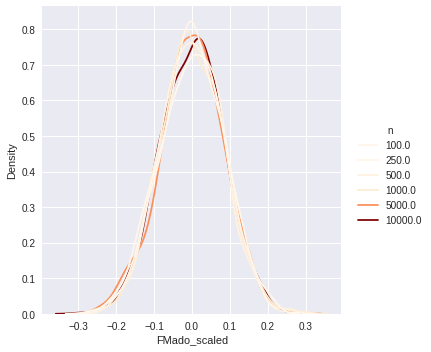

In [ ]:
cmap = cm.get_cmap('OrRd')
sns.displot(data = df_FMado, x = "FMado_scaled", hue = "n", palette= cmap, kind = 'kde')
plt.show()

In [ ]:
target = {}

target['niter'] = 1000
target['simulation'] = np.random.multivariate_normal
target['probs_missing'] = [[0.0,0.0],[0.1,0.1],[0.2,0.2],[0.3,0.3],[0.4,0.4],[0.5,0.5]]
target['n_sample'] = [1000]

mean = [0,0]
cov = [[1,0.25],[0.25,1]]
	
dataset = simu_proba(target)
df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['FMado', 'n','gp', 'prob_X', 'prob_Y']

100%|██████████| 1000/1000 [03:34<00:00,  4.67it/s]


In [ ]:
print(df_FMado)

         FMado       n   gp  prob_X  prob_Y
0     0.116876  1000.0  0.0     0.0     0.0
1     0.118664  1000.0  1.0     0.1     0.1
2     0.117770  1000.0  2.0     0.2     0.2
3     0.117205  1000.0  3.0     0.3     0.3
4     0.109348  1000.0  4.0     0.4     0.4
...        ...     ...  ...     ...     ...
5995  0.113526  1000.0  1.0     0.1     0.1
5996  0.110856  1000.0  2.0     0.2     0.2
5997  0.112584  1000.0  3.0     0.3     0.3
5998  0.112192  1000.0  4.0     0.4     0.4
5999  0.108766  1000.0  5.0     0.5     0.5

[6000 rows x 5 columns]


In [ ]:
target = {}

target['niter'] = 1000
target['simulation'] = np.random.multivariate_normal
target['probs_missing'] = [[0.0,0.0],[0.1,0.1],[0.2,0.2],[0.3,0.3],[0.4,0.4],[0.5,0.5]]
n_sample = [50, 100, 250, 500, 1000, 5000, 10000]


mean = [0,0]
cov = [[1,0.25],[0.25,1]]

dataset = []
for n in n_sample:
  target['n_sample'] = [n]
  output = simu_proba(target)
  dataset.extend(output)

df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['FMado', 'n','gp', 'prob_X', 'prob_Y']

100%|██████████| 1000/1000 [1:07:06<00:00,  4.03s/it]


In [ ]:
df_FMado['FMado_scaled'] = (df_FMado.FMado - df_FMado.groupby('n')['FMado'].transform('mean')) * np.sqrt(df_FMado.n)

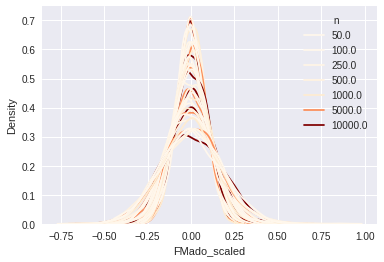

In [ ]:
cmap = "OrRd"
fig, ax = plt.subplots()
for prob in target["probs_missing"]:

  sample = df_FMado.loc[df_FMado['prob_X'] == prob[0], :].copy()
  sample['FMado_scaled'] = (sample.FMado - sample.groupby('n')['FMado'].transform('mean')) * np.sqrt(sample.n)
  sns.kdeplot(data = sample, x = "FMado_scaled", hue = "n", palette= cmap, ax = ax)

